# Ungraded Lab: Image Data Preprocessing with a Validation Set

In this lab, you will build upon the previous exercise and add a validation set. This will let you measure how well the model performs on data it hasn't seen.

## Import the Libraries

Start with importing all the libraries you will need.

In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

## Inspect the Dataset

Similar to the previous lab, you will define the directories containing your images. This time, you will include those with validation data.

In [2]:
TRAIN_DIR = 'horse-or-human'
VAL_DIR = 'validation-horse-or-human'

# Directory with training horse pictures
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')
# Directory with training human pictures
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join(VAL_DIR, 'horses')
# Directory with validation human pictures
validation_human_dir = os.path.join(VAL_DIR, 'humans')

Now see what the filenames look like in these directories:

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_names = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse38-4.png', 'horse34-8.png', 'horse17-7.png', 'horse15-9.png', 'horse36-6.png', 'horse19-5.png', 'horse39-3.png', 'horse18-6.png', 'horse35-7.png', 'horse16-8.png']
TRAIN SET HUMANS: ['human12-13.png', 'human03-22.png', 'human01-06.png', 'human06-10.png', 'human15-01.png', 'human04-30.png', 'human05-02.png', 'human13-21.png', 'human11-05.png', 'human02-14.png']
VAL SET HORSES: ['horse5-235.png', 'horse5-550.png', 'horse1-554.png', 'horse6-153.png', 'horse5-514.png', 'horse3-255.png', 'horse1-455.png', 'horse5-181.png', 'horse2-544.png', 'horse5-002.png']
VAL SET HUMANS: ['valhuman04-00.png', 'valhuman01-12.png', 'valhuman02-20.png', 'valhuman02-02.png', 'valhuman03-10.png', 'valhuman01-21.png', 'valhuman03-01.png', 'valhuman02-11.png', 'valhuman01-03.png', 'valhuman04-08.png']


You can find out the total number of horse and human images in the directories:

In [4]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


Now take a look at a few pictures to get a better sense of what they look like. Display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

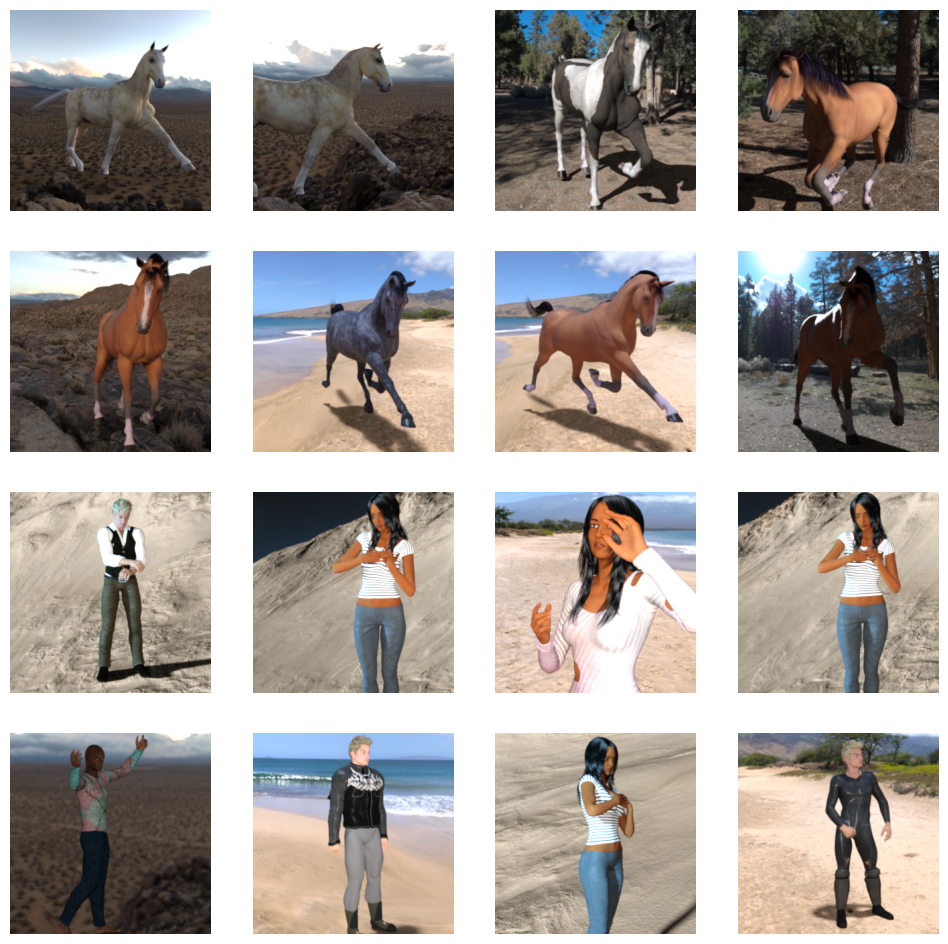

In [5]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in random.sample(train_horse_names, k=8)]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in random.sample(train_human_names, k=8)]

for i, img_path in enumerate(next_horse_pix + next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

You will define the same model architecture as before:

In [6]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0 to 1 where 0 is for 'horses' and 1 for 'humans'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

You will also use the same compile settings as before:

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will setup the datasets with the `tf.data` API. It will mostly be the same as last time but notice the additional code to also prepare the validation data. 

In [9]:
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
    )

# Instantiate the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
    )

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


You will scale both datasets to have `[0,1]` range of pixel values.

In [10]:
# Define the rescaling layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Rescale both datasets
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

As before, you will call a few more methods to configure and optimize your datasets for training. Notice that you don't need to shuffle the validation set. That can be skipped because you are only using the validation set to evaluate the performance of your model. It will not affect how it updates its parameters during training. That is determined purely from the training dataset.

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

# Configure the validation dataset
validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

### Training
Now train the model for 15 epochs. Here, you will pass parameters for `validation_data` and `validation_steps`. With these, you will notice additional outputs in the print statements: `val_loss` and `val_accuracy`. Notice that as you train with more epochs, your training accuracy might go up but your validation accuracy goes down. This can be a sign of overfitting and you need to prevent your model from reaching this point.

In [12]:
history = model.fit(
      train_dataset_final,
      epochs=15,
      validation_data = validation_dataset_final,
      verbose=2)

Epoch 1/15


I0000 00:00:1760108081.079699    1646 service.cc:145] XLA service 0x77bda4002ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760108081.079748    1646 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1760108084.151924    1646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 - 10s - 297ms/step - accuracy: 0.5550 - loss: 0.6871 - val_accuracy: 0.8672 - val_loss: 0.4846
Epoch 2/15
33/33 - 1s - 17ms/step - accuracy: 0.8822 - loss: 0.4509 - val_accuracy: 0.7891 - val_loss: 1.2069
Epoch 3/15
33/33 - 1s - 17ms/step - accuracy: 0.9065 - loss: 0.2726 - val_accuracy: 0.8828 - val_loss: 0.7726
Epoch 4/15
33/33 - 1s - 17ms/step - accuracy: 0.9357 - loss: 0.2122 - val_accuracy: 0.7188 - val_loss: 1.5418
Epoch 5/15
33/33 - 1s - 17ms/step - accuracy: 0.9620 - loss: 0.1033 - val_accuracy: 0.8750 - val_loss: 0.8494
Epoch 6/15
33/33 - 1s - 17ms/step - accuracy: 0.9698 - loss: 0.0922 - val_accuracy: 0.8516 - val_loss: 2.2704
Epoch 7/15
33/33 - 1s - 17ms/step - accuracy: 0.9649 - loss: 0.1203 - val_accuracy: 0.8438 - val_loss: 1.8455
Epoch 8/15
33/33 - 1s - 17ms/step - accuracy: 0.9805 - loss: 0.0808 - val_accuracy: 0.8398 - val_loss: 1.1132
Epoch 9/15
33/33 - 1s - 17ms/step - accuracy: 0.9815 - loss: 0.1133 - val_accuracy: 0.8359 - val_loss: 2.2691
Epoch 10/15
33/33 -

Now that you have a validation set you can plot the accuracy of the training vs validation set over the course of the training.

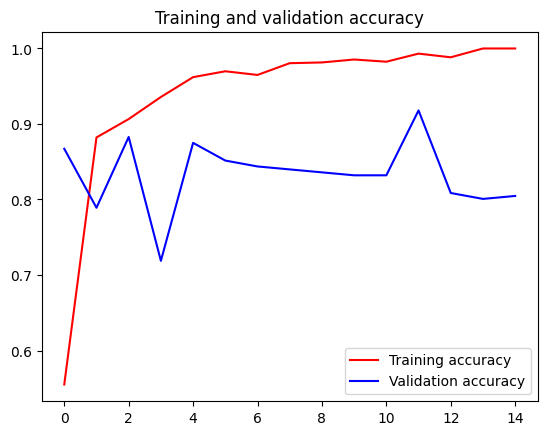

In [13]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

When training accuracy outperforms validation accuracy this is usually a sign that your model is overfitting. You will learn more about what to do about this in Course 2!

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [14]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a human")
        else:
            print(filename + " is a horse")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Visualizing Intermediate Representations

As before, you can plot how the features are transformed as it goes through each layer.

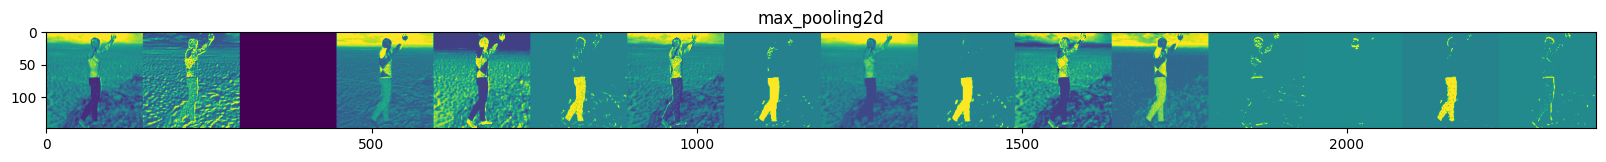

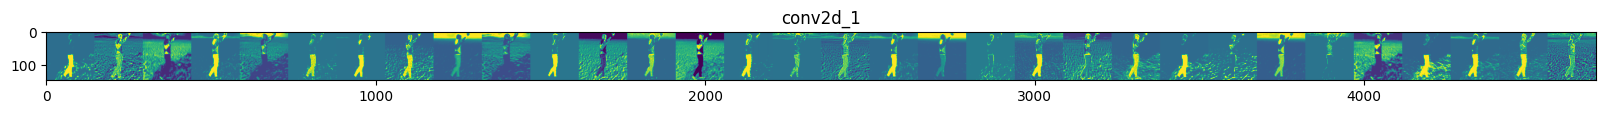

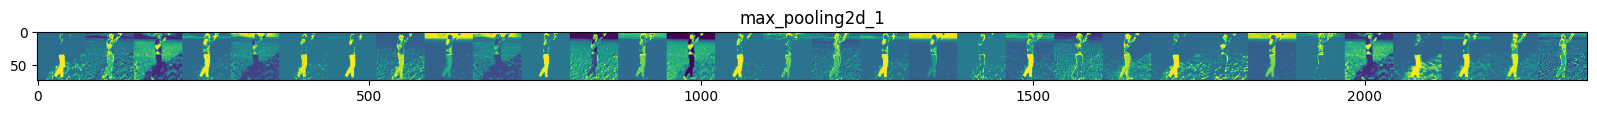

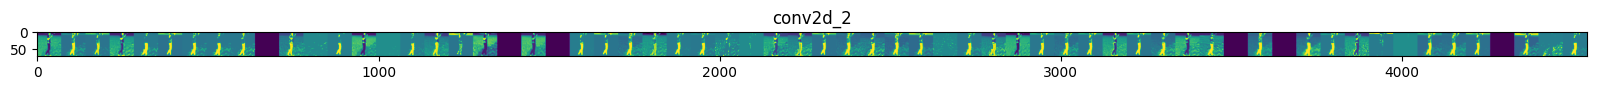

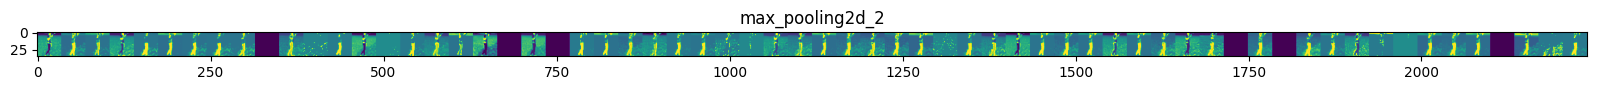

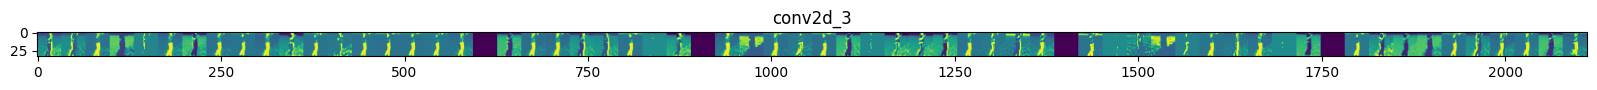

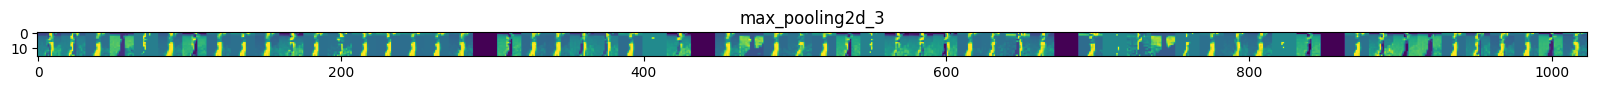

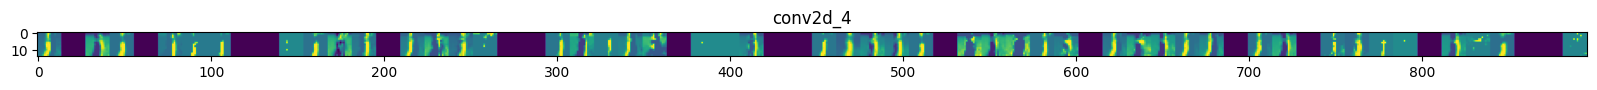

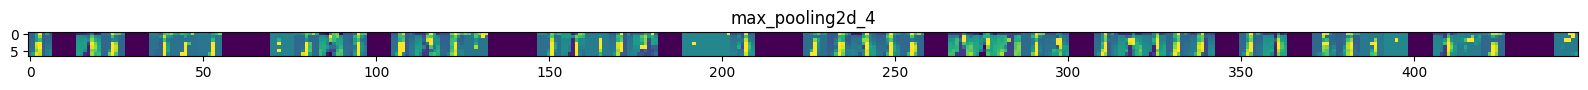

In [15]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = tf.keras.utils.load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = tf.keras.utils.img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x = rescale_layer(x)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x, verbose=False)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Wrap Up

Great job completing this lab! In the next one, you will see how compacting images can affect your results. As before, please run the cell below to free up resources for the next lab.

In [16]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}